# Model Designation

The model developed in this use case belongs to the class of supervised deep learning models for solving regression tasks. Here are further explanations regarding the designation of the model.

- Supervised means that there is a reference against which performance of the model can be objectivley evaluated, within a formal protocol for evaluating models for solving regression tasks.

- Deep learning means that the model will be based on the technology of artificial neural networks (ANNs), which significantly differs in comparison to the classical ML models, when it comes to the methodology of model training and testing, usage of computational resources, and most importantly, logic for making inferences which model obtains after completion of training process.

- Regression means that the objective of a model is to predict numerical value (members of the set of real numbers) whichoriginte from a continous distribution. (As opposed to classification tasks in which the objective is to predict the integers originating from discrete distribution.) 

Fianally it is important to add, that the model will be designed in such manner that it is possible to evaluate the degree of confidence whihc model has in its own predictions. The basis for this methodology of model development is presented in "What my deep model doesn't know..." (Gal, Y, 2015). Even though this property is a propery of probabilistic ML models, in my oppinion, it is not possible to designate this model as probabilistic.

# Objective of Learning Task

Objective of the learning task is to predict the "temperature in kitchen area" in degrees of Celsius, on the basis of other variables present in the "Appliances energy prediction Data Set" available from the UCI Machine Learning Repository. Reader is encouraged to learn more about the data set in question, having in mind that the emphasis of this use case is on the uncertainty estimate, rather than on data analysis and data exploration.

# Technology Stack

Python programing language has been selected for the purposes of model development. Virtualenv package is utilized for generation of specific environment. Model development is done in Keras, while computatuion is done in TensorFlow, with Eigen as the BLAS computational backend. Data manitpulation is mostly done in numpy because there is there is no pronunced need to use labeled feature and target vectors. Usage of these technologies is encouraged in order to gain repodocuible results.

# Methodology of Model Training and Testing

Modeling process follows basic methodology for training and testing of models which solve regression tasks.

- The data set is split to training, validation, and testing set.
- A simplistic dropout self-normalizing feed-forward (FFD) ANN is constructed and trained.
- Training process continues until no reduction of loss on validation set is recorded for two non-consecutive epoch. Minimal increase in reduction of loss, that needs to be achieved between two non-consecutive epochs, is 0.01 MSE.
- After completion of the training process, model performance is evaluated on the test set. Main component of model performance is its accuracy, which is measured as MAE. Model generalization ability, as the second component of the model performance, is only briefly evaluated.
- Finally, alongside the evaluation of model accuracy, an extensive evaluation of confidence of model into its predictions is made. This uncertianty analysis is the main aspect of use case.

No cross-validation or model fine tuning is performed. The reasoning behind such a simplistic approach to model training and testing, is driven by limitations of the model development environment, especially in the terms of computational resources. Therefore, methodology of model training and testing is designed to meet the requirements of fast development and low computational effort, rather than designed to find best solution in terms of model's generalization ability and accuracy. Model training and testing proces would greatly benefit from introduction of hyper-parameter tuning and cross validation.

Also, it is important to take into account that the main purpose of the use-case is to establish usefullness of the methodology for unceritanty estimation developed by Y. Gal (2015).


# Model Development

First step is to import necessary packages.

In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, Dropout, AlphaDropout
from keras.models import Model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


Now, we proceed with declaration of a class for data holding the names of the features and targets. This class also preforms basic data preparation, hence the name of the class. However, further preparation of the data is performed downstream as well.

In [2]:
class PreparedData:
    def __init__(self, inn):
        self.original_data = inn
        self.prepared_data = None
        self.feature_labels = None
        self.target_labels = None
        # Assign index and convert to date.
        out = inn.copy(deep=True)
        out.index = pd.to_datetime(inn['date'])
        # Drop unnecessary columns.
        out.drop(columns=['date', 'rv1', 'rv2'], inplace=True)
        # Get labels.
        target_labels = [
            label for label in inn.columns if
            ('T1' in label)
            & ('_out' not in label)
            & ('Tdewpoint' not in label)
        ]
        feature_labels = set(out.columns) - set(target_labels)
        self.prepared_data = out
        self.feature_labels = feature_labels
        self.target_labels = target_labels

The purpose of the following function is to create a subset of data by selecting desired columns.

In [3]:
def subset_columns(frame, columns):
    """
    Return numpy array wh. subset of columns.
    """
    return np.array(frame.loc[:, columns])

Previous function is then followed with two utility functions. One, to make feature data sets.

In [4]:
def make_features(training_frame,
                  validation_frame,
                  testing_frame,
                  feature_columns):
    """
    Return a features for training, validation, and testing.
    """
    return (
        subset_columns(
            frame=training_frame,
            columns=feature_columns,
        ),
        subset_columns(
            frame=validation_frame,
            columns=feature_columns,
        ),
        subset_columns(
            frame=testing_frame,
            columns=feature_columns
        )
    )

And another to make targets datata sets.

In [5]:
def make_targets(training_frame,
                 validation_frame,
                 testing_frame,
                 targets_columns):
    """
    Return a features for training, validation, and testing.
    """
    return (
        subset_columns(
            frame=training_frame,
            columns=targets_columns,
        ),
        subset_columns(
            frame=validation_frame,
            columns=targets_columns,
        ),
        subset_columns(
            frame=testing_frame,
            columns=targets_columns
        )
    )

For the purposes of removing redundant code, these two utiliti functions could be merged into single one. Next, utility funcitions are complemented with the function to standardize data.

In [6]:
def compute_mean_and_standard_deviation(table):
    """
    Return mean and standard deviation of the table.
    """
    return np.mean(table, axis=0), np.std(table, axis=0)

Afterwards, declaration of the model is placed into a separate function.

In [7]:
def get_model(dimensionality_of_input):
    """
    Return model.
    """
    # Declare input layer.
    input_layer = Input(shape=(dimensionality_of_input, ))
    # Dropout for input layer.
    dropout_1 = Dropout(rate=.2)(input_layer, training=True)
    # Declare regression layer.
    regression_1 = Dense(
        units=32,
        activation='selu',
        kernel_initializer='lecun_normal'
    )(dropout_1)
    # Dropout for regression layer.
    dropout_2 = AlphaDropout(rate=.5)(regression_1, training=True)
    # Declare regression layer.
    regression_2 = Dense(
        units=32,
        activation='selu',
        kernel_initializer='lecun_normal'
    )(dropout_2)
    # Dropout for regression layer.
    dropout_3 = AlphaDropout(rate=.5)(regression_2, training=True)
    # Declare output layer.
    output = Dense(1, activation='linear')(dropout_3)
    # Return model.
    return Model(inputs=input_layer, outputs=output)

Let us briefly elaborate the model architecture. The model is a simple three layer FFD ANN. In order to obtain uncertianty estimate dropout is added to every layer. Having in mind that, dropout mode nedeeds to be preserved while model is delivering predictions, argument "training=True" is passed in respective functions. Finally, the network is designed as self-normalizing network (SNN), and therefore we can find "selu" activation functions, and "lecun_normal" initialization. To summaryze, the network is MC dropout SN-FFD ANN.

In order to utilize this network, a function for generating predictions needs to be developed as well.

In [8]:
def get_stochastic_predictions(model_for_deployment, input_data, passes):
    """
    Return stochastic predictions according to desired number of passes.
    """
    # Declare a list to store predictions.
    raw_predictions = []
    for forward_pass in range(passes):
        raw_predictions.append(
            model_for_deployment.predict(
                x=input_data, batch_size=len(input_data), verbose=0)
        )
    return np.transpose(np.reshape(
        raw_predictions, newshape=(passes, len(input_data))
    ))

This function, generates model predictions through desired number of forward passes, collects the predictions of each pass and returns them as the numpy array.

Finally, we finish off with a function to generate a table for plotting and analysis of the results.

In [9]:
def get_table_for_plotting_predictions(targets, predictions, variance):
    """
    Return table for plotting predictions.
    """
    # Get table wh. data for plotting.
    plotting_table = pd.DataFrame({
        'targets': targets, 'predictions': predictions, 'variance': variance
    })
    plotting_table['upper_limit'] = \
        plotting_table['predictions'] + plotting_table['variance']
    plotting_table['lower_limit'] = \
        plotting_table['predictions'] - plotting_table['variance']
    return plotting_table

Now we are ready to initiate the model development process. We firstley, get the data and instantiate "PreparedData" class.

In [11]:
if __name__ == '__main__':

    # Declare file handles.
    RAW_DATA = r'M:\Projects\004_mc_dropout\1_data\energydata_complete.csv'

    # Get data.
    raw_data = pd.read_csv(RAW_DATA, sep=',')

    # Prepare data.
    data_preparation = PreparedData(inn=raw_data)
    prepared_data = data_preparation.prepared_data

Then, we declare start and end timestamps for training, validation, and testing sets.

In [12]:
    # Declare limits for subsets of data set.
    training_start = 0
    training_end = int(len(prepared_data)/2 - len(prepared_data)/2*.1)
    validation_start = int(len(prepared_data)/2 - len(prepared_data)/2*.1)
    validation_end = int(len(prepared_data)/2)
    testing_start = int(len(prepared_data)/2)
    testing_end = len(prepared_data)

Training data is subsetted first.


In [13]:
    # Subset samples for training.
    features_and_targets_for_training = \
        prepared_data.iloc[training_start:training_end, :]

And here we can see the start, and end timestamps.

In [14]:
    # Print starting and ending times.
    print('Start of training: %s. End of training: %s.' % (
        features_and_targets_for_training.index[0],
        features_and_targets_for_training.index[-1]
    ))

Start of training: 2016-01-11 17:00:00. End of training: 2016-03-13 08:50:00.


In [15]:
    # Shuffle training set.
    np.random.seed(0)
    features_and_targets_for_training = \
        features_and_targets_for_training.iloc[
            np.random.permutation(len(
                features_and_targets_for_training
            )), :
        ]

Then, we subset validation and testing set. No shuffling is done on these sets.

In [16]:
    # Subset samples for validation.
    features_and_targets_for_validation = \
        prepared_data.iloc[validation_start:validation_end, :]

    # Subset samples for testing.
    features_and_targets_for_testing = \
        prepared_data.iloc[testing_start:testing_end, :]

Let us take a look at start and end timestamps of these data sets.

In [17]:
    print('Start of validation: %s. End of validation: %s.' % (
        features_and_targets_for_validation.index[0],
        features_and_targets_for_validation.index[-1]
    ))
    print('Start of training: %s. End of training: %s.' % (
        features_and_targets_for_testing.index[0],
        features_and_targets_for_testing.index[-1]
    ))

Start of validation: 2016-03-13 09:00:00. End of validation: 2016-03-20 05:20:00.
Start of training: 2016-03-20 05:30:00. End of training: 2016-05-27 18:00:00.


Now, we can move on and subset features.

In [18]:
    # Get features.
    features_training, features_validation, features_testing = \
        make_features(
            training_frame=features_and_targets_for_training,
            validation_frame=features_and_targets_for_validation,
            testing_frame=features_and_targets_for_testing,
            feature_columns=data_preparation.feature_labels,
        )

And also, subset targets.

In [19]:
    # Get targets.
    y_train, y_validation, y_test = make_targets(
        training_frame=features_and_targets_for_training,
        validation_frame=features_and_targets_for_validation,
        testing_frame=features_and_targets_for_testing,
        targets_columns=data_preparation.target_labels,
    )

Now it is time to compute the mean and standard deviation of the training set.

In [20]:
    # Get mean and standard deviation of training features.
    mean, standard_deviation = compute_mean_and_standard_deviation(
        table=features_training
    )

And, then it is possible to use these to standardize training set, as well as to rescale validation and tesing set to the units of training set.

In [21]:
    # Standardize training, validation, and testing features.
    x_train = (features_training-mean) / standard_deviation
    x_validation = (features_validation-mean) / standard_deviation
    x_test = (features_testing-mean) / standard_deviation

Let us take a look at the variances of the three sets.

In [22]:
    print(np.var(x_train, axis=0))
    print(np.var(x_validation, axis=0))
    print(np.var(x_test, axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
[0.87941373 0.74120142 0.16078519 0.41331868 0.04869117 0.0703394
 0.20565271 0.58681752 0.6743218  0.10223157 1.15865454 0.3124564
 0.54285796 1.09058073 1.18307181 0.41685807 1.93688439 0.16557348
 0.06666029 0.27765162 0.30501772 0.75422202 1.3665739  0.25435944
 0.65862733]
[0.41874729 2.5185316  1.85421244 0.52631285 2.49731804 0.62236422
 0.64130847 1.75868663 2.10412644 0.81455222 2.28147666 1.12648601
 1.73711587 1.6243543  0.78632384 0.60882017 0.536103   0.61950162
 0.369263   0.71785236 1.36839702 1.70935316 2.09215122 0.92568494
 0.76336401]


It is clear thath there is a shift in the distribution of the data, that is present in the validation, and testing set, where variance of variables assumes different values, far from 1. Let us get the model.

In [28]:
    # Get model.
    model = get_model(dimensionality_of_input=np.shape(x_train)[1])

Here is model summary.

In [29]:
    # Print model summary.
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                832       
_________________________________________________________________
alpha_dropout_3 (AlphaDropou (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
alpha_dropout_4 (AlphaDropou (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total para

Next line compiles the model.

In [30]:
    # Compile model.
    model.compile(
        optimizer='Adam',
        loss='mse',
        metrics=['mae']
    )

Finally, the model is ready for training.

In [31]:
    # Fit model.
    model.fit(
        x=x_train,
        y=y_train,
        epochs=20,
        batch_size=2,
        shuffle=False,
        validation_data=[
            x_validation,
            y_validation
        ],
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                min_delta=0.01,
                patience=2,
                verbose=1
            )
        ]
    )

Train on 8880 samples, validate on 987 samples
Epoch 1/20
8880/8880 [==============================] - 6s 660us/step - loss: 76.6278 - mean_absolute_error: 6.1714 - val_loss: 7.9878 - val_mean_absolute_error: 2.2714
Epoch 2/20
8880/8880 [==============================] - 6s 632us/step - loss: 2.4527 - mean_absolute_error: 1.1762 - val_loss: 1.0033 - val_mean_absolute_error: 0.8129
Epoch 3/20
8880/8880 [==============================] - 6s 632us/step - loss: 0.7900 - mean_absolute_error: 0.6691 - val_loss: 0.6922 - val_mean_absolute_error: 0.6599
Epoch 4/20
8880/8880 [==============================] - 6s 654us/step - loss: 0.6184 - mean_absolute_error: 0.5990 - val_loss: 0.7242 - val_mean_absolute_error: 0.6902
Epoch 5/20
8880/8880 [==============================] - 6s 628us/step - loss: 0.5449 - mean_absolute_error: 0.5622 - val_loss: 0.6202 - val_mean_absolute_error: 0.6439
Epoch 6/20
8880/8880 [==============================] - 6s 661us/step - loss: 0.5143 - mean_absolute_error: 0.54

In order to get the predictions, we make a call to the function designed to do this.

In [32]:
    # Generate predictions.
    predictions_table = get_stochastic_predictions(
        model_for_deployment=model,
        passes=30,
        input_data=x_test,
    )

Now, we can compute the mean of all predictions.

In [33]:
    # Compute predictive mean.
    mean_predictions = np.mean(predictions_table, axis=1)

As well as variance of the predictions.

In [34]:
    # Compute variance.
    variance_of_predictions = np.std(predictions_table, axis=1)
    tau = 1**2*(1-.5)/(2*len(x_test)*0.001)
    predictive_variance = variance_of_predictions + tau**-1

For the purposes of the evaluation model performance, mean absolute error (MAE) is computed.

In [35]:
    # Compute accuracy (MAE).
    mae = np.round(np.mean(np.abs(
        y_test.flatten()-mean_predictions)), decimals=2
    )

In next line we create the table for plotting and analysis of the results. 

In [36]:
    # Get table wh. data for plotting.
    table_for_plotting = get_table_for_plotting_predictions(
        targets=y_test.flatten(),
        predictions=mean_predictions,
        variance=variance_of_predictions
    )

And now, let us take a look at the outcome.

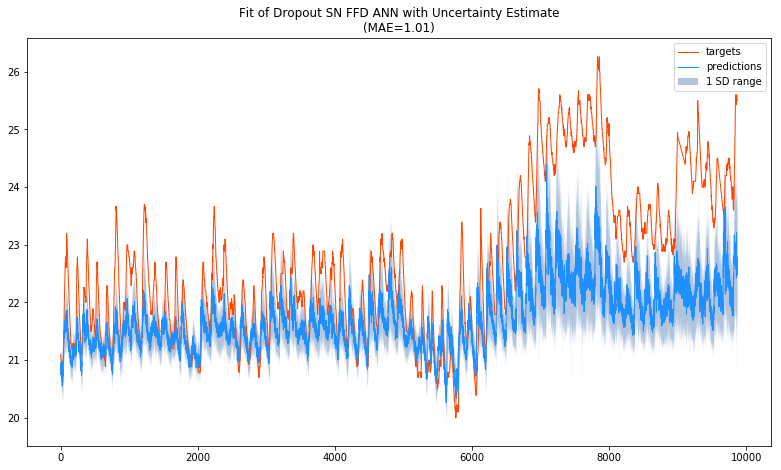

In [38]:
    # Plotting.
    plt.figure(figsize=[26.6667*.5, 15*.5])
    plt.plot(
        table_for_plotting['targets'],
        color='orangered',
        linewidth=1
    )
    plt.plot(
        table_for_plotting['predictions'],
        color='dodgerblue',
        linewidth=1
    )
    variance_band = plt.fill_between(
        table_for_plotting.index,
        table_for_plotting['predictions'] - table_for_plotting['variance'],
        table_for_plotting['predictions'] + table_for_plotting['variance'],
        alpha=1,
        color='lightsteelblue',
        linewidth=0,
        label='1 SD range'
    )
    plt.title(
        'Fit of Dropout SN FFD ANN with Uncertainty Estimate\n(MAE=%s)'
        %
        str(mae)
    )
    plt.legend(loc=1)

As we can see, the model with MC drouput gave predictive mean of the target variable, as well as the variance of the predictions. The analysis reveals that during testing model achieves accuracy of 1.01 degress of Celsius. Performence of the model, deteriorates towards the end of testing interval, and now thanks to the uncertianty estimate we can confirm that it is more likely, due to the shift in distribution of the incoming data, rather than the underlying function that was derived by the model. Furthermore, we can hypothesise that the models generalization ability is retained, because the MAE during validation is 0.61, which is not far away from the MAE in testing, which comprises the erros occuring because of the shift in the distribution of the incoming data.